In [ ]:
import gdown
import zipfile
import os

file_id = '1FdXPjxxouKwnRzDDHsDu73hXnTzIInI2'
output_zip = "satellitedatasetdl.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_zip, quiet=False)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall("satellitedatasetdl")
os.remove(output_zip)

Downloading...
From (original): https://drive.google.com/uc?id=1FdXPjxxouKwnRzDDHsDu73hXnTzIInI2
From (redirected): https://drive.google.com/uc?id=1FdXPjxxouKwnRzDDHsDu73hXnTzIInI2&confirm=t&uuid=9b02bed0-b6cb-46ed-86c2-741fb2749b0f
To: /content/satellitedatasetdl.zip
100%|██████████| 61.2M/61.2M [00:02<00:00, 30.0MB/s]


In [ ]:
dataset_path = os.listdir("/content/satellitedatasetdl/satellitedatasetdl")
print(dataset_path)

['.DS_Store', 'PermanentCrop', 'River', 'Pasture', 'Forest', 'AnnualCrop', 'HerbaceousVegetation']


In [ ]:
import pandas as pd
dataset_directory = "/content/satellitedatasetdl/satellitedatasetdl"

class_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

data = []

for class_name, class_directory in enumerate(class_directories):
    class_directory_path = os.path.join(dataset_directory, class_directory)
    class_files = os.listdir(class_directory_path)
    data.extend([(class_directory, os.path.join(class_directory_path, filename)) for filename in class_files])
df = pd.DataFrame(data, columns=['label', 'image_path'])

print(df)

                      label                                         image_path
0             PermanentCrop  /content/satellitedatasetdl/satellitedatasetdl...
1             PermanentCrop  /content/satellitedatasetdl/satellitedatasetdl...
2             PermanentCrop  /content/satellitedatasetdl/satellitedatasetdl...
3             PermanentCrop  /content/satellitedatasetdl/satellitedatasetdl...
4             PermanentCrop  /content/satellitedatasetdl/satellitedatasetdl...
...                     ...                                                ...
15995  HerbaceousVegetation  /content/satellitedatasetdl/satellitedatasetdl...
15996  HerbaceousVegetation  /content/satellitedatasetdl/satellitedatasetdl...
15997  HerbaceousVegetation  /content/satellitedatasetdl/satellitedatasetdl...
15998  HerbaceousVegetation  /content/satellitedatasetdl/satellitedatasetdl...
15999  HerbaceousVegetation  /content/satellitedatasetdl/satellitedatasetdl...

[16000 rows x 2 columns]


In [ ]:
# Group the DataFrame by 'label' and count the number of occurrences
image_counts = df.groupby('label').size()
print("Number of images in each category:")
print(image_counts)
total_images = image_counts.sum()
print("\nTotal number of images:", total_images)

Number of images in each category:
label
AnnualCrop              3000
Forest                  3000
HerbaceousVegetation    3000
Pasture                 2000
PermanentCrop           2500
River                   2500
dtype: int64

Total number of images: 16000


In [ ]:
from PIL import Image
import numpy as np

output_directory = "/content/resized_images"

os.makedirs(output_directory, exist_ok=True)

# Function to resize and normalize an image
def resize_and_normalize_image(image_path, output_path, target_size=(224, 224)):
    try:
        with Image.open(image_path) as img:
            resized_img = img.resize(target_size)
            normalized_img = np.array(resized_img) / 255.0
            Image.fromarray((normalized_img * 255).astype(np.uint8)).save(output_path)
    except Exception as e:
        print(f"Error resizing image {image_path}: {e}")

for root, _, files in os.walk(dataset_directory):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            image_path = os.path.join(root, file)
            output_path = os.path.join(output_directory, file)
            resize_and_normalize_image(image_path, output_path)

print("Resizing and normalization complete.")

Resizing and normalization complete.


In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

class_labels = []

for class_label, class_directory in enumerate(os.listdir(dataset_directory)):
    class_directory_path = os.path.join(dataset_directory, class_directory)
    if os.path.isdir(class_directory_path):
        class_labels += [class_label] * len(os.listdir(class_directory_path))

class_labels = np.array(class_labels)

# Instantiate LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(class_labels)
print("Mapping of class names to encoded labels:")
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

# Convert the encoded labels to one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
onehot_labels = onehot_encoder.fit_transform(encoded_labels.reshape(-1, 1))

print("\nShape of one-hot encoded labels:", onehot_labels.shape)

Mapping of class names to encoded labels:
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

Shape of one-hot encoded labels: (16000, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from sklearn.compose import ColumnTransformer

dataset_directory = "/content/satellitedatasetdl/satellitedatasetdl"

class_labels = []

for class_label, class_directory in enumerate(os.listdir(dataset_directory)):
    class_directory_path = os.path.join(dataset_directory, class_directory)
    if os.path.isdir(class_directory_path):
        class_labels += [class_label] * len(os.listdir(class_directory_path))

# Convert the list of class labels to numpy array
y = np.array(class_labels).reshape(-1, 1)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder()
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y)

print(Y[:5])
print(Y[35:])

  (0, 0)	1.0
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (0, 0)	1.0
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (5, 0)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 0)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 0)	1.0
  (14, 0)	1.0
  (15, 0)	1.0
  (16, 0)	1.0
  (17, 0)	1.0
  (18, 0)	1.0
  (19, 0)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 0)	1.0
  (24, 0)	1.0
  :	:
  (15940, 5)	1.0
  (15941, 5)	1.0
  (15942, 5)	1.0
  (15943, 5)	1.0
  (15944, 5)	1.0
  (15945, 5)	1.0
  (15946, 5)	1.0
  (15947, 5)	1.0
  (15948, 5)	1.0
  (15949, 5)	1.0
  (15950, 5)	1.0
  (15951, 5)	1.0
  (15952, 5)	1.0
  (15953, 5)	1.0
  (15954, 5)	1.0
  (15955, 5)	1.0
  (15956, 5)	1.0
  (15957, 5)	1.0
  (15958, 5)	1.0
  (15959, 5)	1.0
  (15960, 5)	1.0
  (15961, 5)	1.0
  (15962, 5)	1.0
  (15963, 5)	1.0
  (15964, 5)	1.0


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Create data generator with data augmentation for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

train_dir = "/content/satellitedatasetdl/satellitedatasetdl"

img_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 16000 images belonging to 6 classes.


In [ ]:
#Model training and evaluation
from tensorflow.keras.applications import DenseNet121, EfficientNetB0, VGG16, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

num_classes = len(train_generator.class_indices)

# Create DenseNet model
densenet_model = Sequential([
    DenseNet121(include_top=False, input_shape=(150, 150, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')
])

# Create EfficientNet model
efficientnet_model = Sequential([
    EfficientNetB0(include_top=False, input_shape=(150, 150, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')
])

# Create VGG16 model
vgg16_model = Sequential([
    VGG16(include_top=False, input_shape=(150, 150, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')
])

# Create InceptionV3 model
inceptionv3_model = Sequential([
    InceptionV3(include_top=False, input_shape=(150, 150, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')
])

# Compile models
models = [densenet_model, efficientnet_model, vgg16_model, inceptionv3_model]
model_names = ["DenseNet121", "EfficientNetB0", "VGG16", "InceptionV3"]

for model, name in zip(models, model_names):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train models
epochs = 5
for model, name in zip(models, model_names):
    print(f"Training {name}...")
    model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs
    )
    print(f"{name} training completed.\n")

87910968/87910968 [==============================] - 1s 0us/step
Training DenseNet121...
Epoch 1/5
500/500 [==============================] - 256s 339ms/step - loss: 1.3877 - accuracy: 0.7032
Epoch 2/5
500/500 [==============================] - 172s 345ms/step - loss: 1.5179 - accuracy: 0.6608
Epoch 3/5
500/500 [==============================] - 170s 339ms/step - loss: 0.9471 - accuracy: 0.7216
Epoch 4/5
500/500 [==============================] - 170s 339ms/step - loss: 0.7047 - accuracy: 0.7666
Epoch 5/5
500/500 [==============================] - 158s 317ms/step - loss: 0.5967 - accuracy: 0.7926
DenseNet121 training completed.

Training EfficientNetB0...
Epoch 1/5
500/500 [==============================] - 176s 270ms/step - loss: 0.7601 - accuracy: 0.8153
Epoch 2/5
500/500 [==============================] - 136s 272ms/step - loss: 0.4567 - accuracy: 0.8864
Epoch 3/5
500/500 [==============================] - 138s 275ms/step - loss: 0.4220 - accuracy: 0.9003
Epoch 4/5
500/500 [========

In [ ]:
from tabulate import tabulate
accuracy_results = {
    "Model": model_names,
    "Accuracy": [0.7926, 0.9287, 0.7458, 0.8945]
}

print(tabulate(accuracy_results, headers='keys', tablefmt='grid'))

+----------------+------------+
| Model          |   Accuracy |
+================+============+
| DenseNet121    |     0.7926 |
+----------------+------------+
| EfficientNetB0 |     0.9287 |
+----------------+------------+
| VGG16          |     0.7458 |
+----------------+------------+
| InceptionV3    |     0.8945 |
+----------------+------------+


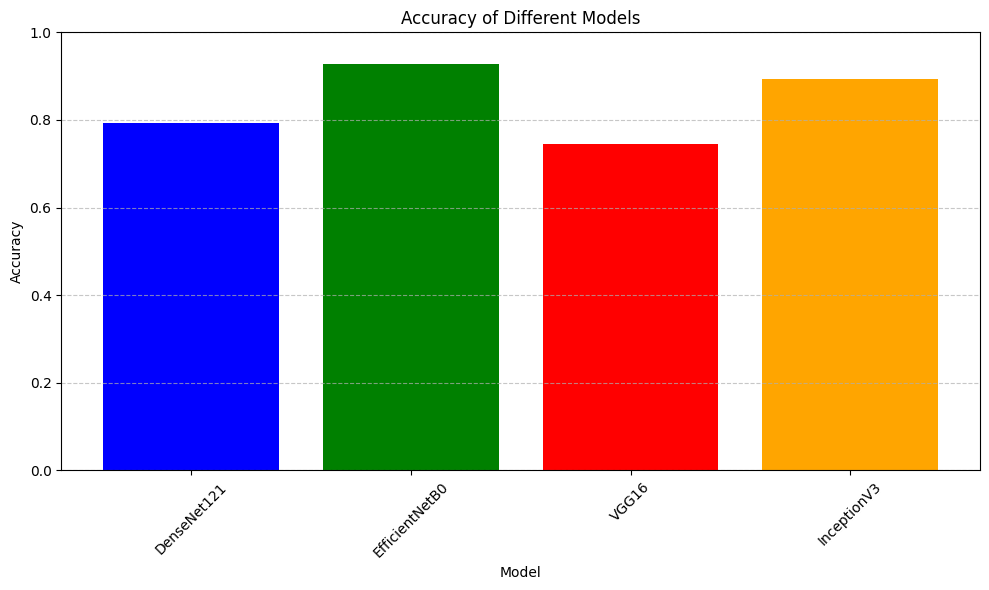

In [ ]:
import matplotlib.pyplot as plt

model_names = accuracy_results["Model"]
accuracies = accuracy_results["Accuracy"]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Dataset Link : https://drive.google.com/file/d/1FdXPjxxouKwnRzDDHsDu73hXnTzIInI2/view?usp=drive_link